In [1]:
pip install sklearn

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install pmdarima

Note: you may need to restart the kernel to use updated packages.


pip install pystan==2.19.1.1

pip install prophet

pip install gluonts

In [4]:
import pandas as pd
import pmdarima as pm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error as mse 
from sklearn.metrics import mean_absolute_error as mae 

In [5]:
df = pd.read_csv('data_GE.csv')

df.set_index('datum', inplace = True)

df.index = pd.to_datetime(df.index)

df.sort_index(inplace = True)

df.head()

,cases_FR,diff_cases_FR,diff_2_cases_FR,cases_GE,diff_cases_GE,diff_2_cases_GE,cases_GR,diff_cases_GR,diff_2_cases_GR,cases_JU,...,test_TI,diff_test_TI,diff_2_test_TI,test_VD,diff_test_VD,diff_2_test_VD,test_VS,diff_test_VS,diff_2_test_VS,vac_all
datum,,,,,,,,,,,,,,,,,,,,,
2020-03-01,0.285714,0.000000,-0.285714,1.428571,0.142857,0.142857,1.285714,0.142857,-0.142857,0.142857,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-03-02,0.285714,0.000000,0.000000,1.714286,0.285714,0.142857,1.285714,0.000000,-0.142857,0.142857,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-03-03,0.714286,0.428571,0.428571,1.714286,0.000000,-0.285714,1.428571,0.142857,0.142857,0.285714,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-03-04,1.000000,0.285714,-0.142857,1.714286,0.000000,0.000000,1.142857,-0.285714,-0.428571,0.571429,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-03-05,1.142857,0.142857,-0.142857,1.857143,0.142857,0.142857,1.285714,0.142857,0.428571,0.571429,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### ARIMA and SARIMA model

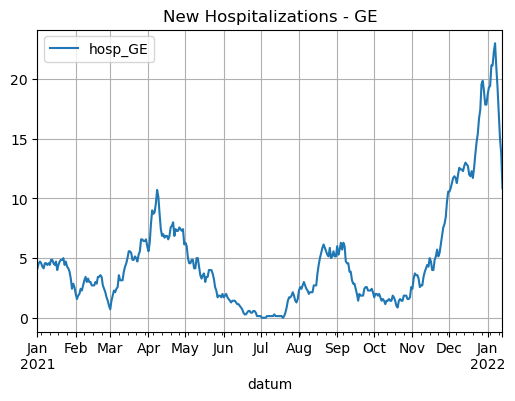

In [6]:
fig, ax = plt.subplots(dpi = 100)

df = df.loc['2021-01-01':]
df['hosp_GE'].plot(ax = ax)

ax.set_title('New Hospitalizations - GE')
ax.legend()
ax.grid()

plt.show()

Checking if the data is stationarity:

In [7]:
from statsmodels.tsa.stattools import adfuller

test_result=adfuller(np.diff(df['hosp_GE']))

if test_result[1] <= 0.05:
    
    print('Data is stationary')

Data is stationary


Checking the autocorrelation and partial correlation of the data:

/srv/conda/envs/saturn/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


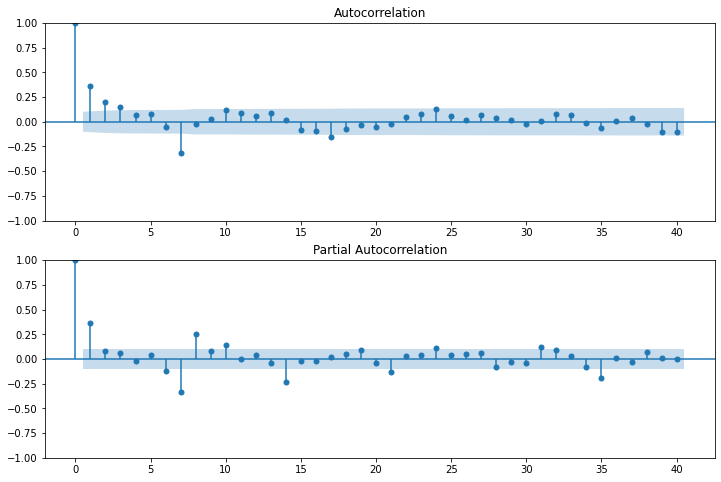

In [8]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(np.diff(df['hosp_GE']),lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(np.diff(df['hosp_GE']),lags=40,ax=ax2)

plt.show()

In [9]:
def ARIMA_model(train):
    # train a ARIMA model
    modl1 = pm.auto_arima(train, start_p=1, start_q=1,
                             max_p=15, max_q=15, max_d = 3, 
                             stepwise=True, suppress_warnings=True,
                             error_action='ignore',m=7)
    
    # train a SARIMA model
    modl2 = pm.auto_arima(train, start_p=1, start_q=1,
                             max_p=15, max_q=15, max_d = 3, 
                             stepwise=True, suppress_warnings=True,
                             error_action='ignore',m=1)

    # Select the model with the lowest AIC
    if modl1.aic() <= modl2.aic():
        modl = modl1
    else:
        modl = modl2
        
    return modl

In [10]:
%%time

train = df['hosp_GE'].iloc[:-14]
modl = ARIMA_model(train)

test = df[['hosp_GE']].iloc[-14:]
# Create predictions for the future, evaluate on test
preds, conf_int = modl.predict(n_periods=test.shape[0], return_conf_int=True)

# Print the error:
print("Test RMSE: %.3f" % np.sqrt(mse(test, preds)))

Test RMSE: 4.234
CPU times: user 1min 6s, sys: 1.3 s, total: 1min 7s
Wall time: 33.9 s


In [11]:
modl

ARIMA(order=(0, 2, 2), scoring_args={}, seasonal_order=(2, 0, 0, 7),
      suppress_warnings=True, with_intercept=False)

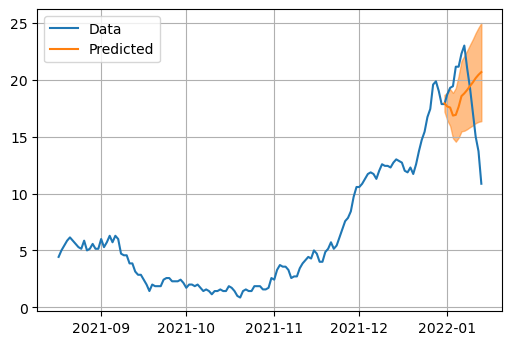

In [12]:
fig, ax = plt.subplots(dpi = 100)

ax.plot(df['hosp_GE'][-150:], label = 'Data')

ax.plot(df.iloc[-14:].index, preds, label = 'Predicted')

ax.fill_between(df.iloc[-14:].index, conf_int[:,0], conf_int[:,1], color = 'tab:orange', alpha = 0.5)

ax.grid()
ax.legend()

plt.show()

### Rotina de validação para o modelo

In [13]:
len(df)

378

In [14]:
%%time
preds_arima = np.array([])
conf_1 = ([])
conf_2 = ([])


for i in np.arange(1,30,1):
    train = df[['hosp_GE']].iloc[:30 + (i-1)*14]

    test = df[['hosp_GE']].iloc[30 + (i-1)*14 :30+ 14*i]

    arima = pm.ARIMA(order=(0, 2, 2), seasonal_order=(2, 0, 0, 7))
    
    arima.fit(train)

    # Create predictions for the future, evaluate on test
    preds_p, conf_int = arima.predict(n_periods=test.shape[0], return_conf_int=True)
    
    preds_arima = np.concatenate( (preds_arima, preds_p) ) 
    
    conf_1 = np.concatenate( (conf_1, conf_int[:,0]) )
    
    conf_2 = np.concatenate( (conf_2, conf_int[:,1]) )
    
    if len(test) != 14:
        
        break
    
    

/srv/conda/envs/saturn/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/srv/conda/envs/saturn/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/srv/conda/envs/saturn/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


CPU times: user 21.8 s, sys: 436 ms, total: 22.2 s
Wall time: 9.07 s


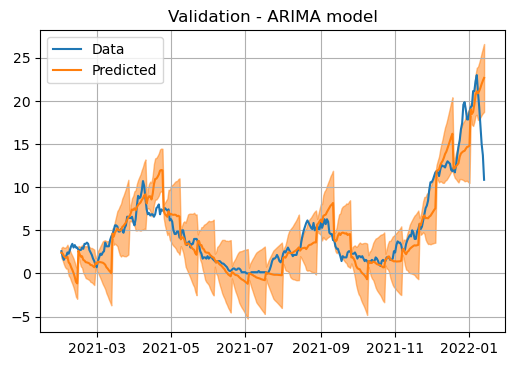

In [15]:
fig, ax = plt.subplots(dpi = 100)

ax.plot(df['hosp_GE'][30:], label = 'Data')

ax.plot(df.iloc[30:].index, np.array(preds_arima).flatten(), label = 'Predicted')

ax.fill_between(df.iloc[30:].index, np.array(conf_1).flatten(), np.array(conf_2).flatten(), color = 'tab:orange', alpha = 0.5)

ax.grid()
ax.legend()
ax.set_title('Validation - ARIMA model')
plt.show()

### HoltWinters model

In [16]:
from statsmodels.tsa.holtwinters import Holt


In [17]:
train = df['hosp_GE'].iloc[:-14]
    

test = df[['hosp_GE']].iloc[-14:]

holt_winter = Holt(train)

holt_winter = holt_winter.fit()

preds = holt_winter.forecast(14)

/srv/conda/envs/saturn/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


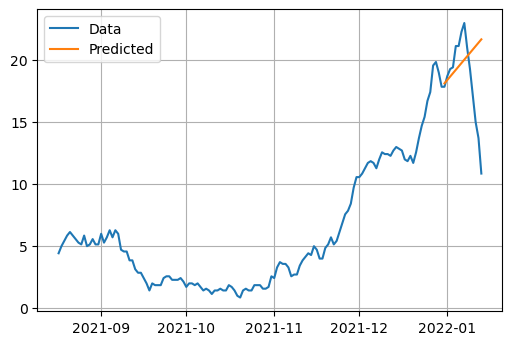

In [18]:
fig, ax = plt.subplots(dpi = 100)

ax.plot(df['hosp_GE'][-150:], label = 'Data')

ax.plot(df.iloc[-14:].index, preds, label = 'Predicted')

ax.grid()
ax.legend()

plt.show()

### Validation

In [19]:
%%time
preds_holt = np.array([])

for i in np.arange(1,30,1):
    train = df[['hosp_GE']].iloc[:30 + (i-1)*14]

    test = df[['hosp_GE']].iloc[30 + (i-1)*14 :30+ 14*i]
    
    holt_winter = Holt(train)

    holt_winter = holt_winter.fit()

    preds_p = holt_winter.forecast(test.shape[0])

    preds_holt = np.concatenate( (preds_holt, preds_p) ) 
    
    if len(test) != 14:
        
        break

/srv/conda/envs/saturn/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/srv/conda/envs/saturn/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/srv/conda/envs/saturn/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/srv/conda/envs/saturn/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/srv/conda/envs/saturn/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:536

CPU times: user 564 ms, sys: 16.4 ms, total: 581 ms
Wall time: 555 ms


/srv/conda/envs/saturn/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/srv/conda/envs/saturn/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


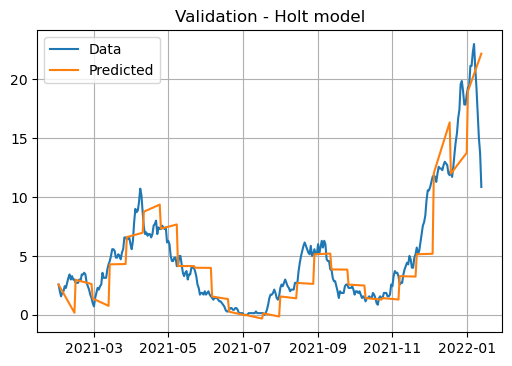

In [20]:
fig, ax = plt.subplots(dpi = 100)

ax.plot(df['hosp_GE'][30:], label = 'Data')

ax.plot(df.iloc[30:].index, np.array(preds_holt).flatten(), label = 'Predicted')

ax.grid()
ax.legend()
ax.set_title('Validation - Holt model')
plt.show()

 Computing the metrics according to the validation plots:

In [21]:
df_metrics = pd.DataFrame()

df_metrics['models'] = ['arima', 'holt']

df_metrics['mse'] = [mse(df['hosp_GE'][30:].values, preds_arima), mse(df['hosp_GE'][30:].values, np.array(preds_holt).flatten())]

df_metrics['mae'] = [mae(df['hosp_GE'][30:].values, preds_arima), mae(df['hosp_GE'][30:].values, np.array(preds_holt).flatten())]

df_metrics

,models,mse,mae
0,arima,3.734629,1.350029
1,holt,3.931966,1.361502


### Linear Regression

In [53]:
import statsmodels.api as sm

In [57]:

def GLM_one(target_name,T,  data, ini_date = '2020-03-01',split = 0.75, maxlag=14):


    target = data[target_name]

    df_lag = build_lagged_features(copy.deepcopy(data), maxlag=maxlag )

    ini_date = max(df_lag.index[0],target.index[0], datetime.strptime(ini_date, "%Y-%m-%d"))

    df_lag = df_lag[ini_date:]
    target = target[ini_date:]
    df_lag = df_lag.dropna()


    # remove the target column and columns related with the day that we want to predict 
    df_lag = df_lag.drop(data.columns, axis = 1)


    # targets 
    targets = {}
    
    horizon_forecast = T
            
    targets[T] = target.shift(-(T - 1))[:-(T - 1)]
    
    #print('size of df_lag', len(df_lag))
    #print('size of targets', len(targets[T]))

    X_train, X_test, y_train, y_test = train_test_split(df_lag, target, train_size=split, test_size=1 - split, shuffle=False)

    idx = pd.period_range(start=df_lag.index[0], end=df_lag.index[-1], freq='14D')
    
    idx = idx.to_timestamp()

    # predictions 
    tgt = targets[T][:len(X_train)]
    
    #print('tgt')
    #print(type(tgt))
    #print(tgt.shape)
    
    #scx = MinMaxScaler()
    #scy = MinMaxScaler()
    
    #X_train = scx.fit_transform(X_train)
    
    #tgt = scy.fit_transform(tgt.values.reshape(-1,1))

    model = sm.GLM(tgt, X_train)

    model = model.fit()

    pred = model.predict(df_lag.iloc[:len(targets[T])]) 

    # transformando preds em um array
    train_size = len(X_train)
    point = targets[T].index[train_size]

    #pred_window = preds5.shape[1]
    #llist = range(len(targets[1].index) - (preds5.shape[1]))
    
    #print(llist)

    y50 = np.array(pred)
    
    #yglm = np.array(predglm)

    x= pd.period_range(start=df_lag.index[T], end=df_lag.index[-1], freq='D').to_timestamp()
    
    x = np.array(x)
    
    target = targets[T]
    
    train_size = len(X_train)
    
    dif = len(x) - len(y50)
        
    if dif <0:
        y50 = y50[:len(y50) + dif]
        
    df = pd.DataFrame()
    df['target'] = target[1:]
    df['date'] = x
    #df['glm'] = yglm[1:]
    df['median'] = y50
    #df['upper'] = y95
    df['train_size'] = [train_size]*len(df)
    
    return df

def GLM_mul(target_name, data, ini_date = '2020-03-01',split = 0.75, horizon_forecast = 14, maxlag=15):

    target = data[target_name]

    df_lag = build_lagged_features(copy.deepcopy(data), maxlag=maxlag )
    
    ini_date = max(df_lag.index[0],target.index[0], datetime.strptime(ini_date, "%Y-%m-%d"))

    df_lag = df_lag[ini_date:]
    target = target[ini_date:]
    target = target.dropna()
    df_lag = df_lag.dropna()

    # remove the target column and columns related with the day that we want to predict 
    df_lag = df_lag.drop(data.columns, axis = 1)

    # targets 
    targets = {}

    for T in np.arange(1,horizon_forecast+1,1):
        if T == 1:
            targets[T] = target.shift(-(T - 1))
        else:
            targets[T] = target.shift(-(T - 1))[:-(T - 1)]

    X_train, X_test, y_train, y_test = train_test_split(df_lag, target, train_size=split, test_size=1 - split, shuffle=False)
    
    # scaling the data 
    #scx = MinMaxScaler()
    #X_train = scx.fit_transform(X_train)
    
    if np.sum(target) > 0.0: 

        idx = pd.period_range(start=df_lag.index[0], end=df_lag.index[-1], freq='14D')
        
        idx = idx.to_timestamp()
        
        # predictions 
        #preds5 = np.empty((len(idx), horizon_forecast))
        preds50 = np.empty((len(idx), horizon_forecast))
        #preds95 = np.empty((len(idx), horizon_forecast))


        for T in range(1, horizon_forecast + 1):

            tgt = targets[T][:len(X_train)]
            
            
            #print('tgt')
            #print(type(tgt))
            #print(tgt.shape)
            
            
            i = 0
            
            while i < len(tgt):
                if tgt[i] <= 0:
                    
                    tgt[i] = 0.01
                i = i+1
                
            # predictions 
    
            scy = MinMaxScaler()
    
            model = sm.GLM(tgt, X_train)

            model = model.fit()
            
            pred = model.predict( df_lag.loc[idx]) 

            #pred50 = pred.median()

            #pred5, pred95 = pred.interval(alpha = 0.95)

            #preds5[:, (T - 1)] = pred5
            preds50[:, (T - 1)] = np.array(pred)
            #preds95[:, (T - 1)] = pred95


        # transformando preds em um array
        train_size = len(X_train)

        #y5 = preds5.flatten()
        y50 = preds50.flatten()
        #y95 = preds95.flatten()

        x= pd.period_range(start=df_lag.index[1], end=df_lag.index[-1], freq='D').to_timestamp()
        
        x = np.array(x)
        
        #y5 = np.array(y5)
        
        y50 = np.array(y50)
        
        #y95 = np.array(y95)
        
        target = targets[1]
        
        train_size = len(X_train)
        
        dif = len(x) - len(y50)
            
        if dif <0:
            #y5 = y5[:len(y5) + dif]
            y50 = y50[:len(y50) + dif]
            #y95 = y95[:len(y95) + dif]
            
        df_pred = pd.DataFrame()
        df_pred['target'] = target[1:]
        df_pred['date'] = x
        #df_pred['lower'] = y5
        df_pred['median'] = y50
        #df_pred['upper'] = y95
        df_pred['train_size'] = [train_size]*len(df_pred)
        df_pred['canton'] = [target_name[-2:]]*len(df_pred)

    else:
        x= pd.period_range(start=df_lag.index[1], end=df_lag.index[-1], freq='D').to_timestamp()
        
        x = np.array(x)

        df_pred = pd.DataFrame()
        df_pred['target'] = target[1:]
        df_pred['date'] = x
        #df_pred['lower'] = [0.0]*len(df_pred)
        df_pred['median'] =[ 0.0]*len(df_pred)
        #df_pred['upper'] = [0.0]*len(df_pred)
        df_pred['train_size'] = [len(X_train)]*len(df_pred)
        df_pred['canton'] = [target_name[-2:]]*len(df_pred)

    
    return df_pred


In [56]:
df = pd.read_csv('data_GE.csv')
df.set_index('datum', inplace = True)

df.index = pd.to_datetime(df.index)

#df = df.loc['2021-01-01':]
df_n = pd.DataFrame()

for i in df.columns:
    
    if i.endswith('GE'):
        
        df_n[i] = df[i]

df_n['vac_all'] = df['vac_all']
df_n

,cases_GE,diff_cases_GE,diff_2_cases_GE,hosp_GE,diff_hosp_GE,diff_2_hosp_GE,test_GE,diff_test_GE,diff_2_test_GE,vac_all
datum,,,,,,,,,,
2020-03-01,1.428571,0.142857,0.142857,0.428571,0.000000,0.285714,0.000000,0.000000,0.000000,0.000000
2020-03-02,1.714286,0.285714,0.142857,0.428571,0.000000,0.142857,0.000000,0.000000,0.000000,0.000000
2020-03-03,1.714286,0.000000,-0.285714,0.428571,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-03-04,1.714286,0.000000,0.000000,0.571429,0.142857,0.142857,0.000000,0.000000,0.000000,0.000000
2020-03-05,1.857143,0.142857,0.142857,0.857143,0.285714,0.142857,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...
2022-01-09,2443.428571,-1.142857,-119.857143,19.285714,-1.714286,0.285714,6920.285714,130.428571,-189.428571,162.535714
2022-01-10,2520.571429,77.142857,78.285714,17.142857,-2.142857,-0.428571,7029.142857,108.857143,-21.571429,163.337143
2022-01-11,2515.857143,-4.714286,-81.857143,15.000000,-2.142857,0.000000,7106.714286,77.571429,-31.285714,164.125714


In [58]:
%%time
target_name = 'hosp_GE'

T = 14

df_preds_one = GLM_one(target_name,T,  df_n, ini_date = '2020-03-01',split = 0.75, maxlag=14)

df_preds_mul = GLM_mul(target_name, df_n, ini_date = '2020-03-01',split = 0.75, maxlag=14)


CPU times: user 1.89 s, sys: 43 ms, total: 1.93 s
Wall time: 496 ms


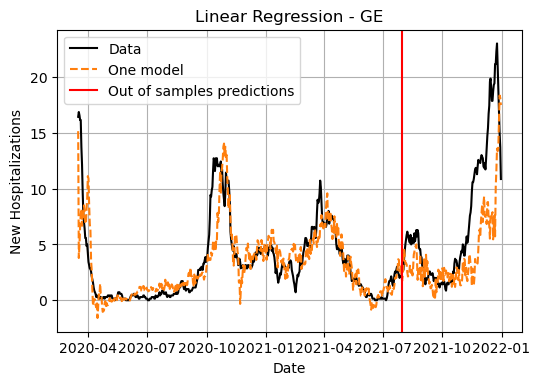

In [59]:
fig, ax = plt.subplots(dpi = 100)

ax.plot(df_preds_one.target, label = 'Data', color = 'black')

ax.plot(df_preds_one['median'], label = 'One model',ls = '--', color = 'tab:orange')
   
#ax.plot(df_preds_3['median'], label = 'SVR - rbf', ls = '--', color = 'tab:green')
    
ax.axvline(df_preds_one.index[df_preds_one.train_size[0]], 0,20,   color = 'red', label = 'Out of samples predictions')
    
ax.set_xlabel('Date')
    
ax.set_ylabel('New Hospitalizations')

ax.grid()
ax.legebnd()
ax.set_title('Linear Regression - GE')
plt.show()

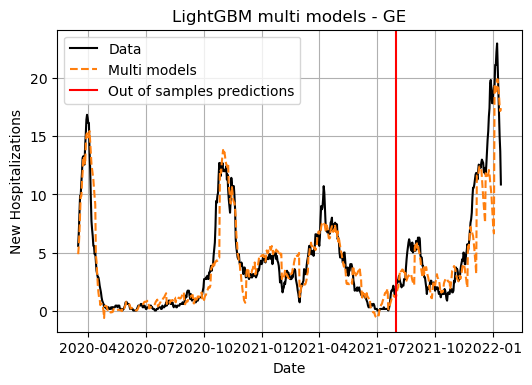

In [60]:
fig, ax = plt.subplots(dpi = 100)

ax.plot(df_preds_mul.target, label = 'Data', color = 'black')

ax.plot(df_preds_mul['median'], label = 'Multi models',ls = '--', color = 'tab:orange')
   
#ax.plot(df_preds_3['median'], label = 'SVR - rbf', ls = '--', color = 'tab:green')
    
ax.axvline(df_preds_mul.index[df_preds_mul.train_size[0]], 0,20,   color = 'red', label = 'Out of samples predictions')
    
ax.set_xlabel('Date')
    
ax.set_ylabel('New Hospitalizations')

ax.grid()
ax.legend()
ax.set_title('LightGBM multi models - GE')
plt.show()

In [61]:
df_metrics = pd.DataFrame()

df_metrics['models'] = ['GLM - one', 'GLM - mult']

df_metrics['mse'] = [mse(df_preds_one.target.values, df_preds_one['median'].values), mse(df_preds_mul.target.values, df_preds_mul['median'].values)]

df_metrics['mae'] = [mae(df_preds_one.target.values, df_preds_one['median'].values), mae(df_preds_mul.target.values, df_preds_mul['median'].values)]
df_metrics

,models,mse,mae
0,GLM - one,8.687726,1.722462
1,GLM - mult,3.357254,1.061410


## Machine Learning models 

In [22]:
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler
import lightgbm as lgb
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
import copy

In [23]:
df = pd.read_csv('data_GE.csv')
df.set_index('datum', inplace = True)

df.index = pd.to_datetime(df.index)

#df = df.loc['2021-01-01':]
df

,cases_GE,diff_cases_GE,diff_2_cases_GE,hosp_GE,diff_hosp_GE,diff_2_hosp_GE,test_GE,diff_test_GE,diff_2_test_GE,vac_all
datum,,,,,,,,,,
2020-03-01,1.428571,0.142857,0.142857,0.428571,0.000000,0.285714,0.000000,0.000000,0.000000,0.000000
2020-03-02,1.714286,0.285714,0.142857,0.428571,0.000000,0.142857,0.000000,0.000000,0.000000,0.000000
2020-03-03,1.714286,0.000000,-0.285714,0.428571,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-03-04,1.714286,0.000000,0.000000,0.571429,0.142857,0.142857,0.000000,0.000000,0.000000,0.000000
2020-03-05,1.857143,0.142857,0.142857,0.857143,0.285714,0.142857,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...
2022-01-09,2443.428571,-1.142857,-119.857143,19.285714,-1.714286,0.285714,6920.285714,130.428571,-189.428571,162.535714
2022-01-10,2520.571429,77.142857,78.285714,17.142857,-2.142857,-0.428571,7029.142857,108.857143,-21.571429,163.337143
2022-01-11,2515.857143,-4.714286,-81.857143,15.000000,-2.142857,0.000000,7106.714286,77.571429,-31.285714,164.125714


In [24]:
df_n = pd.DataFrame()

for i in df.columns:
    
    if i.endswith('GE'):
        
        df_n[i] = df[i]

df_n['vac_all'] = df['vac_all']
df_n

,cases_GE,diff_cases_GE,diff_2_cases_GE,hosp_GE,diff_hosp_GE,diff_2_hosp_GE,test_GE,diff_test_GE,diff_2_test_GE,vac_all
datum,,,,,,,,,,
2020-03-01,1.428571,0.142857,0.142857,0.428571,0.000000,0.285714,0.000000,0.000000,0.000000,0.000000
2020-03-02,1.714286,0.285714,0.142857,0.428571,0.000000,0.142857,0.000000,0.000000,0.000000,0.000000
2020-03-03,1.714286,0.000000,-0.285714,0.428571,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-03-04,1.714286,0.000000,0.000000,0.571429,0.142857,0.142857,0.000000,0.000000,0.000000,0.000000
2020-03-05,1.857143,0.142857,0.142857,0.857143,0.285714,0.142857,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...
2022-01-09,2443.428571,-1.142857,-119.857143,19.285714,-1.714286,0.285714,6920.285714,130.428571,-189.428571,162.535714
2022-01-10,2520.571429,77.142857,78.285714,17.142857,-2.142857,-0.428571,7029.142857,108.857143,-21.571429,163.337143
2022-01-11,2515.857143,-4.714286,-81.857143,15.000000,-2.142857,0.000000,7106.714286,77.571429,-31.285714,164.125714


In [25]:
def build_lagged_features(dt, maxlag=2, dropna=True):
    '''
    Builds a new DataFrame to facilitate regressing over all possible lagged features
    :param dt: Dataframe containing features
    :param maxlag: maximum lags to compute
    :param dropna: if true the initial rows containing NANs due to lagging will be dropped
    :return: Dataframe
    '''
    if type(dt) is pd.DataFrame:
        new_dict = {}
        for col_name in dt:
            new_dict[col_name] = dt[col_name]
            # create lagged Series
            for l in range(1, maxlag + 1):
                new_dict['%s_lag%d' % (col_name, l)] = dt[col_name].shift(l)
        res = pd.DataFrame(new_dict, index=dt.index)

    elif type(dt) is pd.Series:
        the_range = range(maxlag + 1)
        res = pd.concat([dt.shift(i) for i in the_range], axis=1)
        res.columns = ['lag_%d' % i for i in the_range]
    else:
        print('Only works for DataFrame or Series')
        return None
    if dropna:
        return res.dropna()
    else:
        return res


In [26]:
def rolling_predictions_one(model, target_name,T,  data, ini_date = '2020-03-01',split = 0.75, maxlag=14):


    target = data[target_name]

    df_lag = build_lagged_features(copy.deepcopy(data), maxlag=maxlag )

    ini_date = max(df_lag.index[0],target.index[0], datetime.strptime(ini_date, "%Y-%m-%d"))

    df_lag = df_lag[ini_date:]
    target = target[ini_date:]
    df_lag = df_lag.dropna()


    # remove the target column and columns related with the day that we want to predict 
    df_lag = df_lag.drop(data.columns, axis = 1)


    # targets 
    targets = {}
    
    horizon_forecast = T
            
    targets[T] = target.shift(-(T - 1))[:-(T - 1)]
    
    #print('size of df_lag', len(df_lag))
    #print('size of targets', len(targets[T]))

    X_train, X_test, y_train, y_test = train_test_split(df_lag, target, train_size=split, test_size=1 - split, shuffle=False)

    idx = pd.period_range(start=df_lag.index[0], end=df_lag.index[-1], freq='14D')
    
    idx = idx.to_timestamp()

    # predictions 
    tgt = targets[T][:len(X_train)]
    
    #print('tgt')
    #print(type(tgt))
    #print(tgt.shape)
    
    scx = MinMaxScaler()
    scy = MinMaxScaler()
    
    X_train = scx.fit_transform(X_train)
    
    tgt = scy.fit_transform(tgt.values.reshape(-1,1))

    model.fit(X_train, tgt.ravel())

    pred = model.predict( scx.transform(df_lag.iloc[:len(targets[T])]) )

    # transformando preds em um array
    train_size = len(X_train)
    point = targets[T].index[train_size]

    #pred_window = preds5.shape[1]
    #llist = range(len(targets[1].index) - (preds5.shape[1]))
    
    #print(llist)

    y50 = np.array(scy.inverse_transform(pred.reshape(-1,1)))
    
    #yglm = np.array(predglm)

    x= pd.period_range(start=df_lag.index[T], end=df_lag.index[-1], freq='D').to_timestamp()
    
    x = np.array(x)
    
    target = targets[T]
    
    train_size = len(X_train)
    
    dif = len(x) - len(y50)
        
    if dif <0:
        y50 = y50[:len(y50) + dif]
        
    df = pd.DataFrame()
    df['target'] = target[1:]
    df['date'] = x
    #df['glm'] = yglm[1:]
    df['median'] = y50
    #df['upper'] = y95
    df['train_size'] = [train_size]*len(df)
    
    return df

def rolling_predictions(model, target_name, data, ini_date = '2020-03-01',split = 0.75, horizon_forecast = 14, maxlag=15):

    target = data[target_name]

    df_lag = build_lagged_features(copy.deepcopy(data), maxlag=maxlag )
    
    ini_date = max(df_lag.index[0],target.index[0], datetime.strptime(ini_date, "%Y-%m-%d"))

    df_lag = df_lag[ini_date:]
    target = target[ini_date:]
    target = target.dropna()
    df_lag = df_lag.dropna()

    # remove the target column and columns related with the day that we want to predict 
    df_lag = df_lag.drop(data.columns, axis = 1)

    # targets 
    targets = {}

    for T in np.arange(1,horizon_forecast+1,1):
        if T == 1:
            targets[T] = target.shift(-(T - 1))
        else:
            targets[T] = target.shift(-(T - 1))[:-(T - 1)]

    X_train, X_test, y_train, y_test = train_test_split(df_lag, target, train_size=split, test_size=1 - split, shuffle=False)
    
    # scaling the data 
    scx = MinMaxScaler()
    X_train = scx.fit_transform(X_train)
    
    if np.sum(target) > 0.0: 

        idx = pd.period_range(start=df_lag.index[0], end=df_lag.index[-1], freq='14D')
        
        idx = idx.to_timestamp()
        
        # predictions 
        #preds5 = np.empty((len(idx), horizon_forecast))
        preds50 = np.empty((len(idx), horizon_forecast))
        #preds95 = np.empty((len(idx), horizon_forecast))


        for T in range(1, horizon_forecast + 1):

            tgt = targets[T][:len(X_train)]
            
            
            #print('tgt')
            #print(type(tgt))
            #print(tgt.shape)
            
            
            i = 0
            
            while i < len(tgt):
                if tgt[i] <= 0:
                    
                    tgt[i] = 0.01
                i = i+1
                
            # predictions 
    
            scy = MinMaxScaler()
    
            tgt = scy.fit_transform(tgt.values.reshape(-1,1))


            model.fit(X_train, tgt.ravel())
            
            pred = model.predict( scx.transform(df_lag.loc[idx]) )

            #pred50 = pred.median()

            #pred5, pred95 = pred.interval(alpha = 0.95)

            #preds5[:, (T - 1)] = pred5
            preds50[:, (T - 1)] = np.array(scy.inverse_transform(pred.reshape(-1,1)))[:,0]
            #preds95[:, (T - 1)] = pred95


        # transformando preds em um array
        train_size = len(X_train)

        #y5 = preds5.flatten()
        y50 = preds50.flatten()
        #y95 = preds95.flatten()

        x= pd.period_range(start=df_lag.index[1], end=df_lag.index[-1], freq='D').to_timestamp()
        
        x = np.array(x)
        
        #y5 = np.array(y5)
        
        y50 = np.array(y50)
        
        #y95 = np.array(y95)
        
        target = targets[1]
        
        train_size = len(X_train)
        
        dif = len(x) - len(y50)
            
        if dif <0:
            #y5 = y5[:len(y5) + dif]
            y50 = y50[:len(y50) + dif]
            #y95 = y95[:len(y95) + dif]
            
        df_pred = pd.DataFrame()
        df_pred['target'] = target[1:]
        df_pred['date'] = x
        #df_pred['lower'] = y5
        df_pred['median'] = y50
        #df_pred['upper'] = y95
        df_pred['train_size'] = [train_size]*len(df_pred)
        df_pred['canton'] = [target_name[-2:]]*len(df_pred)

    else:
        x= pd.period_range(start=df_lag.index[1], end=df_lag.index[-1], freq='D').to_timestamp()
        
        x = np.array(x)

        df_pred = pd.DataFrame()
        df_pred['target'] = target[1:]
        df_pred['date'] = x
        #df_pred['lower'] = [0.0]*len(df_pred)
        df_pred['median'] =[ 0.0]*len(df_pred)
        #df_pred['upper'] = [0.0]*len(df_pred)
        df_pred['train_size'] = [len(X_train)]*len(df_pred)
        df_pred['canton'] = [target_name[-2:]]*len(df_pred)

    
    return df_pred


### Gradient boosting trees (LightGBM)

In [27]:
def lgbm_model(alpha = 0.5, params=None, **kwargs):
    '''
    Return an LGBM model
    :param kwargs:
    :return: LGBMRegressor model
    '''
    if params is None:
        params = {
            'n_jobs': 8,
            'max_depth': 4,
            'max_bin': 63,
            'num_leaves': 255,
#             'min_data_in_leaf': 1,
            'subsample': 0.9,
            'n_estimators': 200,
            'tree_learner': 'feature', 
            'learning_rate': 0.1,
            'colsample_bytree': 0.9,
            'boosting_type': 'gbdt'
        }


    model = lgb.LGBMRegressor(objective='quantile', alpha = alpha, **params)

    return model 

In [28]:
%%time
target_name = 'hosp_GE'

T = 14

model_lgbm = lgbm_model()

df_preds_one = rolling_predictions_one(model_lgbm,target_name,T,  df_n, ini_date = '2020-03-01',split = 0.75, maxlag=14)

df_preds_mul = rolling_predictions(model_lgbm,target_name, df_n, ini_date = '2020-03-01',split = 0.75, maxlag=14)



CPU times: user 10.5 s, sys: 144 ms, total: 10.6 s
Wall time: 1.38 s


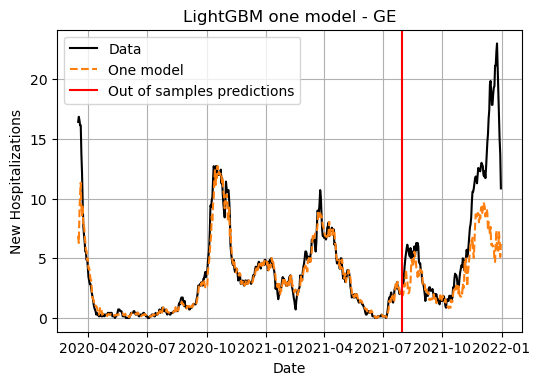

In [29]:
fig, ax = plt.subplots(dpi = 100)

ax.plot(df_preds_one.target, label = 'Data', color = 'black')

ax.plot(df_preds_one['median'], label = 'One model',ls = '--', color = 'tab:orange')
   
#ax.plot(df_preds_3['median'], label = 'SVR - rbf', ls = '--', color = 'tab:green')
    
ax.axvline(df_preds_one.index[df_preds_one.train_size[0]], 0,20,   color = 'red', label = 'Out of samples predictions')
    
ax.set_xlabel('Date')
    
ax.set_ylabel('New Hospitalizations')

ax.grid()
ax.legend()
ax.set_title('LightGBM one model - GE')
plt.show()

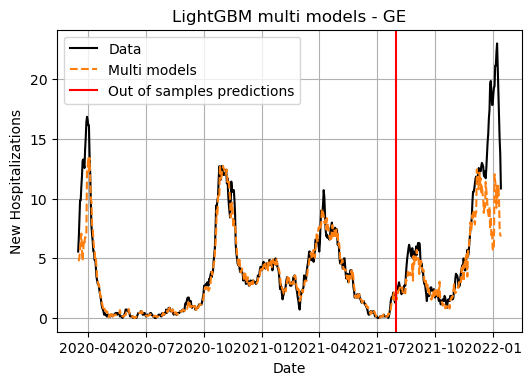

In [30]:
fig, ax = plt.subplots(dpi = 100)

ax.plot(df_preds_mul.target, label = 'Data', color = 'black')

ax.plot(df_preds_mul['median'], label = 'Multi models',ls = '--', color = 'tab:orange')
   
#ax.plot(df_preds_3['median'], label = 'SVR - rbf', ls = '--', color = 'tab:green')
    
ax.axvline(df_preds_mul.index[df_preds_mul.train_size[0]], 0,20,   color = 'red', label = 'Out of samples predictions')
    
ax.set_xlabel('Date')
    
ax.set_ylabel('New Hospitalizations')

ax.grid()
ax.legend()
ax.set_title('LightGBM multi models - GE')
plt.show()

In [31]:
df_metrics = pd.DataFrame()

df_metrics['models'] = ['LGBM - one', 'LGBM - mult']

df_metrics['mse'] = [mse(df_preds_one.target.values, df_preds_one['median'].values), mse(df_preds_mul.target.values, df_preds_mul['median'].values)]

df_metrics['mae'] = [mae(df_preds_one.target.values, df_preds_one['median'].values), mae(df_preds_mul.target.values, df_preds_mul['median'].values)]
df_metrics

,models,mse,mae
0,LGBM - one,6.556647,1.024963
1,LGBM - mult,4.594080,0.879116


### SVR models

In [32]:
%%time
target_name = 'hosp_GE'

T = 14

SVR_1 = SVR(kernel='linear', degree =2, gamma = 'auto', epsilon = 0.01, shrinking = False)

df_preds_1 = rolling_predictions_one(SVR_1,target_name,T,  df_n, ini_date = '2021-01-01',split = 0.75, maxlag=14)

SVR_2 = SVR(kernel='poly', degree =2, gamma = 'auto', epsilon = 0.01, shrinking = False)

df_preds_2 = rolling_predictions_one(SVR_2,target_name,T,  df_n, ini_date = '2021-01-01',split = 0.75, maxlag=14)

SVR_3 = SVR(kernel='rbf', gamma = 'auto', epsilon = 0.01, shrinking = False)

df_preds_3 = rolling_predictions_one(SVR_3,target_name,T,  df_n, ini_date = '2021-01-01',split = 0.75, maxlag=14)


CPU times: user 184 ms, sys: 3.83 ms, total: 188 ms
Wall time: 186 ms


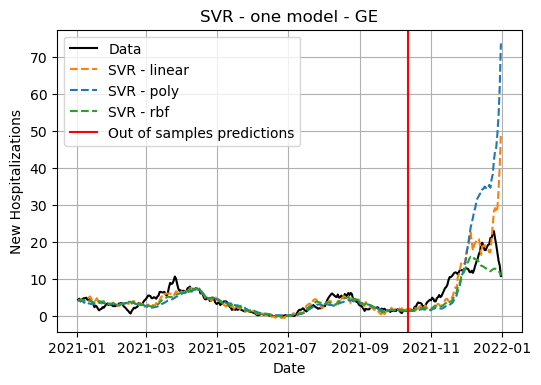

In [33]:
fig, ax = plt.subplots(dpi = 100)

ax.plot(df_preds_1.target, label = 'Data', color = 'black')

ax.plot(df_preds_1['median'], label = 'SVR - linear',ls = '--', color = 'tab:orange')
  
ax.plot(df_preds_2['median'], label = 'SVR - poly', ls = '--', color = 'tab:blue')
  
ax.plot(df_preds_3['median'], label = 'SVR - rbf', ls = '--', color = 'tab:green')
    
ax.axvline(df_preds_1.index[df_preds_1.train_size[0]], 0,20,   color = 'red', label = 'Out of samples predictions')
    
ax.set_xlabel('Date')
    
ax.set_ylabel('New Hospitalizations')

ax.grid()
ax.legend()
ax.set_title('SVR - one model - GE')
plt.show()

In [34]:
df_metrics = pd.DataFrame()

df_metrics['models'] = ['SVR - linear', 'SVR - poly', 'SVR - rbf']

df_metrics['mse'] = [mse(df_preds_1.target.values, df_preds_1['median'].values), mse(df_preds_2.target.values, df_preds_2['median'].values), mse(df_preds_3.target.values, df_preds_3['median'].values)]

df_metrics['mae'] = [mae(df_preds_1.target.values, df_preds_1['median'].values), mae(df_preds_2.target.values, df_preds_2['median'].values), mae(df_preds_3.target.values, df_preds_3['median'].values)]
df_metrics

,models,mse,mae
0,SVR - linear,11.618195,1.528330
1,SVR - poly,45.680507,2.758977
2,SVR - rbf,4.977267,1.380227


In [35]:
%%time
target_name = 'hosp_GE'

T = 14

SVR_1 = SVR(kernel='linear', degree =2, gamma = 'auto', epsilon = 0.01, shrinking = False)

df_preds_1_mul = rolling_predictions(SVR_1,target_name, df_n, ini_date = '2021-01-01',split = 0.75, maxlag=14)

SVR_2 = SVR(kernel='poly', degree =2, gamma = 'auto', epsilon = 0.01, shrinking = False)

df_preds_2_mul = rolling_predictions(SVR_2,target_name, df_n, ini_date = '2021-01-01',split = 0.75, maxlag=14)

SVR_3 = SVR(kernel='rbf', gamma = 'auto', epsilon = 0.01, shrinking = False)

df_preds_3_mul = rolling_predictions(SVR_3,target_name, df_n, ini_date = '2021-01-01',split = 0.75, maxlag=14)



CPU times: user 1.66 s, sys: 0 ns, total: 1.66 s
Wall time: 1.65 s


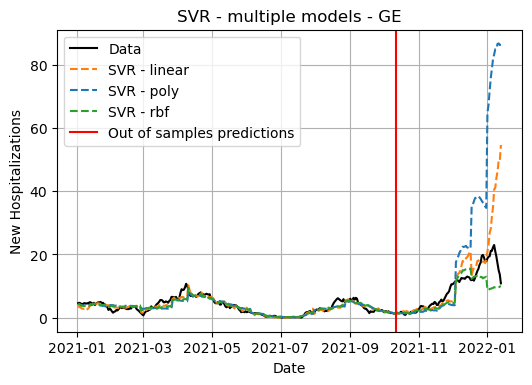

In [36]:
fig, ax = plt.subplots(dpi = 100)

ax.plot(df_preds_1_mul.target, label = 'Data', color = 'black')

ax.plot(df_preds_1_mul['median'], label = 'SVR - linear',ls = '--', color = 'tab:orange')
  
ax.plot(df_preds_2_mul['median'], label = 'SVR - poly', ls = '--', color = 'tab:blue')
  
ax.plot(df_preds_3_mul['median'], label = 'SVR - rbf', ls = '--', color = 'tab:green')
    
ax.axvline(df_preds_1_mul.index[df_preds_1_mul.train_size[0]], 0,20,   color = 'red', label = 'Out of samples predictions')
    
ax.set_xlabel('Date')
    
ax.set_ylabel('New Hospitalizations')

ax.grid()
ax.legend()
ax.set_title('SVR - multiple models - GE')
plt.show()

In [37]:
df_metrics = pd.DataFrame()

df_metrics['models'] = ['SVR - linear (one)', 'SVR - poly (one)', 'SVR - rbf (one)',
                       'SVR - linear (mul)', 'SVR - poly (mul)', 'SVR - rbf (mul)']

df_metrics['mse'] = [mse(df_preds_1.target.values, df_preds_1['median'].values), mse(df_preds_2.target.values, df_preds_2['median'].values), mse(df_preds_3.target.values, df_preds_3['median'].values),
                    
                    mse(df_preds_1_mul.target.values, df_preds_1_mul['median'].values), mse(df_preds_2_mul.target.values, df_preds_2_mul['median'].values), mse(df_preds_3_mul.target.values, df_preds_3_mul['median'].values)]

df_metrics['mae'] = [mae(df_preds_1.target.values, df_preds_1['median'].values), mae(df_preds_2.target.values, df_preds_2['median'].values), mae(df_preds_3.target.values, df_preds_3['median'].values),
                    
                     mae(df_preds_1_mul.target.values, df_preds_1_mul['median'].values), mae(df_preds_2_mul.target.values, df_preds_2_mul['median'].values), mae(df_preds_3_mul.target.values, df_preds_3_mul['median'].values)
                    ]
df_metrics

,models,mse,mae
0,SVR - linear (one),11.618195,1.528330
1,SVR - poly (one),45.680507,2.758977
2,SVR - rbf (one),4.977267,1.380227
3,SVR - linear (mul),20.951990,1.575371
4,SVR - poly (mul),154.714732,4.067830
5,SVR - rbf (mul),5.641711,1.241695


### MLP regressor
Multi-layer Perceptron regressor

In [38]:
%%time
target_name = 'hosp_GE'

T = 14

mlp = MLPRegressor(hidden_layer_sizes = 50, random_state=1, max_iter=1000, shuffle = False, solver = 'adam', learning_rate = 'adaptive', activation = 'relu')

df_preds_1 = rolling_predictions_one(mlp,target_name,T,  df_n, ini_date = '2021-01-01',split = 0.75, maxlag=14)

mlp2 = MLPRegressor(hidden_layer_sizes=50, random_state=1, max_iter=1000, shuffle = False, solver = 'lbfgs', learning_rate = 'adaptive', activation = 'relu')

df_preds_2 = rolling_predictions_one(mlp2,target_name,T,  df_n, ini_date = '2021-01-01',split = 0.75, maxlag=14)



CPU times: user 1.96 s, sys: 27.8 ms, total: 1.98 s
Wall time: 511 ms


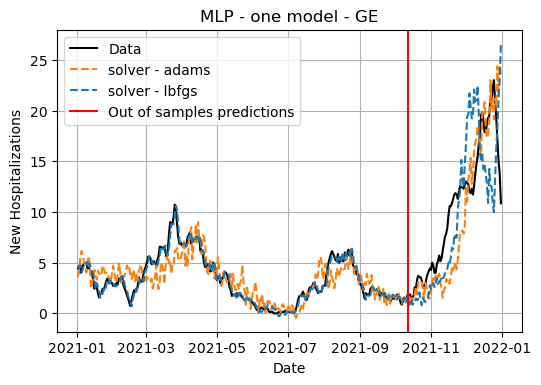

In [39]:
fig, ax = plt.subplots(dpi = 100)

ax.plot(df_preds_1.target, label = 'Data', color = 'black')

ax.plot(df_preds_1['median'], label = 'solver - adams',ls = '--', color = 'tab:orange')
  
ax.plot(df_preds_2['median'], label = 'solver - lbfgs', ls = '--', color = 'tab:blue')
  
#ax.plot(df_preds_3['median'], label = 'solver - lbfgs - learning_rate = adaptive', ls = '--', color = 'tab:green')
    
ax.axvline(df_preds_1.index[df_preds_1.train_size[0]], 0,20,   color = 'red', label = 'Out of samples predictions')
    
ax.set_xlabel('Date')
    
ax.set_ylabel('New Hospitalizations')

ax.grid()
ax.legend()
ax.set_title('MLP - one model - GE')
plt.show()


In [40]:
%%time
target_name = 'hosp_GE'

T = 14

mlp = MLPRegressor(hidden_layer_sizes = 50, random_state=1, max_iter=1000, shuffle = False, solver = 'adam', learning_rate = 'adaptive', activation = 'relu')

df_preds_1_mul = rolling_predictions(mlp,target_name, df_n, ini_date = '2021-01-01',split = 0.75, maxlag=14)

mlp2 = MLPRegressor(hidden_layer_sizes=50, random_state=1, max_iter=1000, shuffle = False, solver = 'lbfgs', learning_rate = 'adaptive', activation = 'relu')

df_preds_2_mul = rolling_predictions(mlp2,target_name, df_n, ini_date = '2021-01-01',split = 0.75, maxlag=14)


CPU times: user 31.6 s, sys: 596 ms, total: 32.2 s
Wall time: 8.06 s


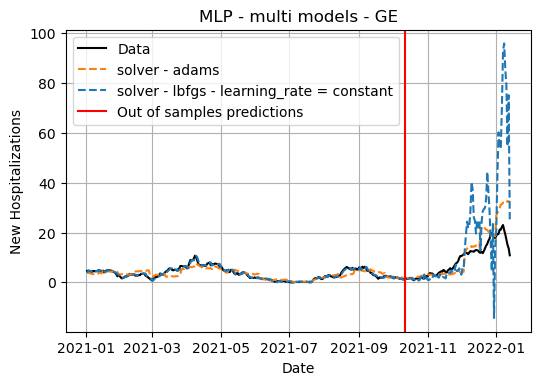

In [41]:
fig, ax = plt.subplots(dpi = 100)

ax.plot(df_preds_1_mul.target, label = 'Data', color = 'black')

ax.plot(df_preds_1_mul['median'], label = 'solver - adams',ls = '--', color = 'tab:orange')
  
ax.plot(df_preds_2_mul['median'], label = 'solver - lbfgs - learning_rate = constant', ls = '--', color = 'tab:blue')
  
ax.axvline(df_preds_1_mul.index[df_preds_1_mul.train_size[0]], 0,20,   color = 'red', label = 'Out of samples predictions')
    
ax.set_xlabel('Date')
    
ax.set_ylabel('New Hospitalizations')

ax.grid()
ax.legend()
ax.set_title('MLP - multi models - GE')
plt.show()#


In [42]:
df_metrics = pd.DataFrame()

df_metrics['models'] = ['MLP (one) - (Adams)', 'MLP (one) - (lbfgs)',
                       'MLP (mult) - (Adams)', 'MLP (mult) - (lbfgs)']

df_metrics['mse'] = [mse(df_preds_1.target.values, df_preds_1['median'].values), mse(df_preds_2.target.values, df_preds_2['median'].values), 
                    
                    mse(df_preds_1_mul.target.values, df_preds_1_mul['median'].values), mse(df_preds_2_mul.target.values, df_preds_2_mul['median'].values),]

df_metrics['mae'] = [mae(df_preds_1.target.values, df_preds_1['median'].values), mae(df_preds_2.target.values, df_preds_2['median'].values),
                    
                     mae(df_preds_1_mul.target.values, df_preds_1_mul['median'].values), mae(df_preds_2_mul.target.values, df_preds_2_mul['median'].values),
                    ]
df_metrics

,models,mse,mae
0,MLP (one) - (Adams),4.945363,1.485024
1,MLP (one) - (lbfgs),5.866730,1.138240
2,MLP (mult) - (Adams),9.442993,1.633862
3,MLP (mult) - (lbfgs),100.889810,2.976890


### LSTM models

In [43]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [44]:
pip install shap

Note: you may need to restart the kernel to use updated packages.


In [45]:
import tensorflow.keras as  keras
from tensorflow.keras.layers import Dense, Activation, Dropout, Bidirectional
from tensorflow.keras.layers import LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
from tensorflow.keras import backend as K
from sklearn.preprocessing import normalize
import scipy.stats as ss
import pickle
import math
import os
import shap
from sklearn.metrics import *

from time import time

2022-01-27 01:59:18.924436: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-27 01:59:18.924464: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [46]:
import tensorflow
print(tensorflow.__version__)

2.7.0


In [47]:
def split_data(df, look_back=12, ratio=0.8, predict_n=5, Y_column=0):
    """
    Split the data into training and test sets
    Keras expects the input tensor to have a shape of (nb_samples, timesteps, features).
    :param df: Pandas dataframe with the data.
    :param look_back: Number of weeks to look back before predicting
    :param ratio: fraction of total samples to use for training
    :param predict_n: number of weeks to predict
    :param Y_column: Column to predict
    :return:
    """
    df = np.nan_to_num(df.values).astype("float64")
    # n_ts is the number of training samples also number of training sets
    # since windows have an overlap of n-1
    n_ts = df.shape[0] - look_back - predict_n + 1
    # data = np.empty((n_ts, look_back + predict_n, df.shape[1]))
    data = np.empty((n_ts, look_back + predict_n, df.shape[1]))
    for i in range(n_ts):  # - predict_):
        #         print(i, df[i: look_back+i+predict_n,0])
        data[i, :, :] = df[i: look_back + i + predict_n, :]
    # train_size = int(n_ts * ratio)
    train_size = int(df.shape[0] * ratio) - look_back
    print(train_size)

    # We are predicting only column 0
    X_train = data[:train_size, :look_back, :]
    Y_train = data[:train_size, look_back:, Y_column]
    X_test = data[train_size:, :look_back, :]
    Y_test = data[train_size:, look_back:, Y_column]

    return X_train, Y_train, X_test, Y_test


def normalize_data(df, log_transform=False):
    """
    Normalize features in the example table
    :param df:
    :return:
    """     
    df.fillna(0, inplace=True)
    norm = normalize(df, norm='max', axis=0)
    if log_transform==True:
        norm = np.log(norm)
    df_norm = pd.DataFrame(norm, columns=df.columns)

    return df_norm, df.max(axis=0)

In [48]:
def build_model(hidden, features, predict_n, look_back=10, batch_size=1):
    """
    Builds and returns the LSTM model with the parameters given
    :param hidden: number of hidden nodes
    :param features: number of variables in the example table
    :param look_back: Number of time-steps to look back before predicting
    :param batch_size: batch size for batch training
    :return:
    """
    leaky_relu = keras.layers.LeakyReLU()
    inp = keras.Input(
        shape=(look_back, features),
        # batch_shape=(batch_size, look_back, features)
    )
    x = Bidirectional(LSTM(
        hidden,
        input_shape=(look_back, features),
        stateful=False,
        kernel_initializer="he_uniform",
        batch_input_shape=(batch_size, look_back, features),
        return_sequences=True,
         activation='relu',
        dropout=0.1,
        recurrent_dropout=0.1,
        implementation=2,
        unit_forget_bias=True,
    ), merge_mode = 'ave')(inp, training=True)
    x = Dropout(0.2)(x, training=True)
    Bidirectional(LSTM(
        hidden,
        input_shape=(look_back, features),
        stateful=False,
        kernel_initializer="he_uniform",
        batch_input_shape=(batch_size, look_back, features),
        return_sequences=True,
         activation='relu',
        dropout=0.1,
        recurrent_dropout=0.1,
        implementation=2,
        unit_forget_bias=True,
    ), merge_mode = 'ave')(inp, training=True)
    x = Dropout(0.2)(x, training=True)
    x =  Bidirectional(LSTM(
        hidden,
        input_shape=(look_back, features),
        kernel_initializer="he_uniform",
        stateful=False,
        batch_input_shape=(batch_size, look_back, features),
        #return_sequences=True,
         activation='relu',
        dropout=0.1,
        recurrent_dropout=0.1,
        implementation=2,
        unit_forget_bias=True,
    ), merge_mode = 'ave')(inp, training=True)
    x = Dropout(0.2)(x, training=True)
    out = Dense(
        predict_n,
        activation='relu',
        kernel_initializer="he_uniform",
        bias_initializer="zeros",
    )(x)
    model = keras.Model(inp, out)

    start = time()
    model.compile(loss="msle", optimizer="adam", metrics=["accuracy", "mape", "mse"])
    print("Compilation Time : ", time() - start)
    plot_model(model, to_file="LSTM_model.png")
    print(model.summary())
    return model


def train(model, X_train, Y_train, batch_size=1, epochs=10, geocode=None, overwrite=True):
    TB_callback = TensorBoard(
        log_dir="./tensorboard",
        histogram_freq=0,
        write_graph=True,
        write_images=True,
        # embeddings_freq=10
    )

    hist = model.fit(
        X_train,
        Y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_split=0.15,
        verbose=1,
        callbacks=[TB_callback, EarlyStopping(patience=15)]
    )
    with open("history_{}.pkl".format(geocode), "wb") as f:
        pickle.dump(hist.history, f)
    model.save_weights("trained_{}_model.h5".format(geocode), overwrite=overwrite)
    return hist


def plot_training_history(hist):
    """
    Plot the Loss series from training the model
    :param hist: Training history object returned by "model.fit()"
    """
    df_vloss = pd.DataFrame(hist.history["val_loss"], columns=["val_loss"])
    df_loss = pd.DataFrame(hist.history["loss"], columns=["loss"])
    df_mape = pd.DataFrame(
        hist.history["mean_absolute_percentage_error"], columns=["mape"]
    )
    ax = df_vloss.plot(logy=True)
    df_loss.plot(ax=ax, grid=True, logy=True)
    # df_mape.plot(ax=ax, grid=True, logy=True);
    # P.savefig("{}/LSTM_training_history.png".format(FIG_PATH))


def plot_predicted_vs_data(predicted, Ydata, indice, label, pred_window, factor, split_point=None, uncertainty=False):
    """
    Plot the model's predictions against data
    :param predicted: model predictions
    :param Ydata: observed data
    :param indice:
    :param label: Name of the locality of the predictions
    :param pred_window:
    :param factor: Normalizing factor for the target variable
    """

    P.clf()
    if len(predicted.shape) == 2:
        df_predicted = pd.DataFrame(predicted)
        df_predicted25 = None
    else:
        df_predicted = pd.DataFrame(np.percentile(predicted, 50, axis=2))
        df_predicted25 = pd.DataFrame(np.percentile(predicted, 2.5, axis=2))
        df_predicted975 = pd.DataFrame(np.percentile(predicted, 97.5, axis=2))
        uncertainty = True
    ymax = max(predicted.max() * factor, Ydata.max() * factor)
    P.vlines(indice[split_point], 0, ymax, "g", "dashdot", lw=2)
    P.text(indice[split_point + 2], 0.6 * ymax, "Out of sample Predictions")
    # plot only the last (furthest) prediction point
    P.plot(indice[len(indice)-Ydata.shape[0]:], Ydata[:, -1] * factor, 'k-', alpha=0.7, label='data')
    P.plot(indice[len(indice)-Ydata.shape[0]:], df_predicted.iloc[:,-1] * factor, 'r-', alpha=0.5, label='median')
    if uncertainty:
        P.fill_between(indice[len(indice)-Ydata.shape[0]:], df_predicted25[df_predicted25.columns[-1]] * factor,
                       df_predicted975[df_predicted975.columns[-1]] * factor,
                       color='b', alpha=0.3)

    # plot all predicted points
    # P.plot(indice[pred_window:], pd.DataFrame(Ydata)[7] * factor, 'k-')
    # for n in range(df_predicted.shape[1] - pred_window):
    #     P.plot(
    #         indice[n: n + pred_window],
    #         pd.DataFrame(Ydata.T)[n] * factor,
    #         "k-",
    #         alpha=0.7,
    #     )
    #     P.plot(indice[n: n + pred_window], df_predicted[n] * factor, "r-")
    #     try:
    #         P.vlines(
    #             indice[n + pred_window],
    #             0,
    #             df_predicted[n].values[-1] * factor,
    #             "b",
    #             alpha=0.2,
    #         )
    #     except IndexError as e:
    #         print(indice.shape, n, df_predicted.shape)
    tag = '_unc' if uncertainty else ''
    P.grid()
    P.title("Predictions for {}".format(label))
    P.xlabel("time")
    P.ylabel("incidence")
    P.xticks(rotation=70)
    P.legend(["data", "predicted"])
    P.savefig(
        "lstm_{}{}.png".format(label, tag),
        bbox_inches="tight",
        dpi=300,
    )
    P.show()


def loss_and_metrics(model, Xtest, Ytest):
    print(model.evaluate(Xtest, Ytest, batch_size=1))


def evaluate(model, Xdata, Ydata, label, uncertainty=False):
    loss_and_metrics(model, Xdata, Ydata)
    metrics = model.evaluate(Xdata, Ydata, batch_size=1)
    # with open('metrics_{}.pkl'.format(label), 'wb') as f:
    #     pickle.dump(metrics, f)
    if uncertainty:
        predicted = np.stack([model.predict(Xdata, batch_size=1, verbose=1) for i in range(100)], axis=2)
    else:
        predicted = model.predict(Xdata, batch_size=1, verbose=1)
    return predicted, metrics


def calculate_metrics(pred, ytrue, factor):
    metrics = pd.DataFrame(
        index=(
            "mean_absolute_error",
            "explained_variance_score",
            "mean_squared_error",
            "mean_squared_log_error",
            "median_absolute_error",
            "r2_score",
        )
    )
    for col in range(pred.shape[1]):
        y = ytrue[:, col] * factor
        p = pred[:, col] * factor
        l = [
            mean_absolute_error(y, p),
            explained_variance_score(y, p),
            mean_squared_error(y, p),
            mean_squared_log_error(y, p),
            median_absolute_error(y, p),
            r2_score(y, p),
        ]
        metrics[col] = l
    return metrics


def train_evaluate_model(target_name, data, predict_n, look_back, hidden, epochs, ratio=0.75, cluster=True, load=False,
                         uncertainty=True):
    """
    Train the model
    :param city: Name of the city
    :param data: Dataset
    :param predict_n: Number of steps ahead to be predicted
    :param look_back: number of history steps to include in training window
    :param hidden: Number of Hidden layer
    :param epochs: number of training epochs
    :param ratio: ratio of the full dataset to use in training
    :param load: Whether to load a previously saved model
    :return:
    """
        
    target_col = data.columns.get_loc("hosp_GE")
   
    norm_data, max_features = normalize_data(data)
    
    factor = max_features[target_col]

    ##split test and train
    X_train, Y_train, X_test, Y_test = split_data(
        norm_data,
        look_back=look_back,
        ratio=ratio,
        predict_n=predict_n,
        Y_column=target_col,
    )
    # print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

    ## Run model
    model = build_model(
        hidden, X_train.shape[2], predict_n=predict_n, look_back=look_back
    )
    #if load:
        #model.load_model("../saved_models/LSTM/{}/lstm_{}_epochs_{}.h5".format(STATE, city, epochs))
        
    history = train(model, X_train, Y_train, batch_size=1, epochs=epochs, geocode=target_name)
    model.save('lstm_{}_epochs_{}.h5'.format(target_name, epochs))

    predicted_out, metrics_out = evaluate(model, X_test, Y_test, label="out_of_sample_{}".format(target_name), uncertainty=uncertainty
    )
    predicted_in, metrics_in = evaluate(model, X_train, Y_train, label="in_sample_{}".format(target_name), uncertainty=uncertainty
    )
    if uncertainty:
        pout = np.percentile(predicted_out, 50, axis=2)
    else:
        pout = predicted_out
    if ratio < 1:
        metrics = calculate_metrics(pout, Y_test, factor)
        metrics.to_pickle(
            "metrics_lstm_{}_8pw.pkl".format(target_name)
        )

    if ratio < 1:
        predicted = np.concatenate((predicted_in, predicted_out), axis=0)
    else:  # In this case there is no Test set (ratio=1)
        predicted = predicted_in
    with open(
            "predicted_lstm_{}_8pw.pkl".format(target_name), "wb"
    ) as f:
        pickle.dump(predicted, f)

    return predicted, X_train, X_test, Y_test, Y_train, factor

In [49]:
%%time

df_n_lstm = df_n.loc['2021-01-01':]
predicted, X_train, X_test, Y_test, Y_train, factor = train_evaluate_model(target_name = 'hosp_GE', data = df_n_lstm,
predict_n = 14, look_back = 21, hidden = 10, epochs = 100, ratio=0.75, cluster=True, load=False,
                         uncertainty= True)

262



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
2022-01-27 01:59:20.546630: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-01-27 01:59:20.546660: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-01-27 01:59:20.546679: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (j-eduar-forecast-analysis-80707d7e90e94633b486c677da0331bfcxqsq): /proc/driver/nvidia/version does not exist
2022-01-27 01:59:20.546903: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU ins

Compilation Time :  0.0049304962158203125
('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 21, 10)]          0         
                                                                 
 bidirectional_2 (Bidirectio  (None, 10)               1680      
 nal)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 10)                0         
                                                                 
 dense (Dense)               (None, 14)                154       
                                                                 
Total params: 1,834
Trainable params: 1,834
Non

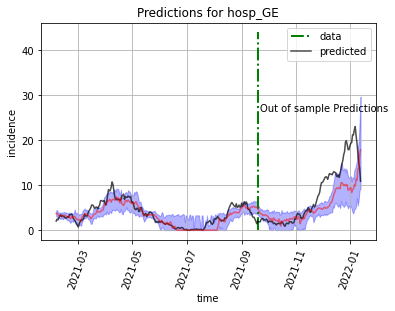

In [50]:
from matplotlib import pyplot as P
indice = list(df_n_lstm.index)
indice = [i.date() for i in indice]
    
plot_predicted_vs_data(
        predicted,
        np.concatenate((Y_train, Y_test), axis=0),
        indice[:],
        label="{}".format('hosp_GE'),
        pred_window=14,
        factor=factor,
        split_point=len(Y_train),
        uncertainty= False
    )

In [51]:
def train_model(target_name, data, predict_n, look_back, hidden, epochs, ratio=0.75, load=False,
                         uncertainty=True):
    """
    Train the model
    :param city: Name of the city
    :param data: Dataset
    :param predict_n: Number of steps ahead to be predicted
    :param look_back: number of history steps to include in training window
    :param hidden: Number of Hidden layer
    :param epochs: number of training epochs
    :param ratio: ratio of the full dataset to use in training
    :param load: Whether to load a previously saved model
    :return:
    """
        
    target_col = data.columns.get_loc("hosp_GE")
   
    norm_data, max_features = normalize_data(data)
    
    factor = max_features[target_col]

    ##split test and train
    X_train, Y_train, X_test, Y_test = split_data(
        norm_data,
        look_back=look_back,
        ratio=ratio,
        predict_n=predict_n,
        Y_column=target_col,
    )
    # print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

    ## Run model
    model = build_model(
        hidden, X_train.shape[2], predict_n=predict_n, look_back=look_back
    )
    #if load:
        #model.load_model("../saved_models/LSTM/{}/lstm_{}_epochs_{}.h5".format(STATE, city, epochs))
        
    history = train(model, X_train, Y_train, batch_size=1, epochs=epochs, geocode=target_name)
    model.save('lstm_{}_epochs_{}.h5'.format(target_name, epochs))

    #predicted_out, metrics_out = evaluate(model, X_test, Y_test, label="out_of_sample_{}".format(target_name), uncertainty=uncertainty
    #)
    #predicted_in, metrics_in = evaluate(model, X_train, Y_train, label="in_sample_{}".format(target_name), uncertainty=uncertainty
    #)
    #if uncertainty:
    #    pout = np.percentile(predicted_out, 50, axis=2)
    #else:
    #    pout = predicted_out
    #if ratio < 1:
    #    metrics = calculate_metrics(pout, Y_test, factor)
    #    metrics.to_pickle(
    #        "metrics_lstm_{}_8pw.pkl".format(target_name)
    #    )

    #if ratio < 1:
    #    predicted = np.concatenate((predicted_in, predicted_out), axis=0)
    #else:  # In this case there is no Test set (ratio=1)
    #    predicted = predicted_in
    #with open(
    #        "predicted_lstm_{}_8pw.pkl".format(target_name), "wb"
    #) as f:
    #    pickle.dump(predicted, f)

    return X_train, X_test, Y_test, Y_train, factor


### Neural model with one output 

In [194]:
def build_simple_model(shape):
    model = models.Sequential()
    model.add(layers.Dense(16, activation='relu',
                           input_shape=(shape,)))
    model.add(layers.Dense(8, activation='relu'))
    model.add(layers.Dense(1, activation = 'relu'))
    model.compile(optimizer='adam', loss='mse', metrics=['mape', 'mse', 'mae'])
    return model

In [195]:
def train_simple_model(target_name,T,  data, ini_date = '2020-03-01',split = 0.75, maxlag=14):


    target = data[target_name]

    df_lag = build_lagged_features(copy.deepcopy(data), maxlag=maxlag )

    ini_date = max(df_lag.index[0],target.index[0], datetime.strptime(ini_date, "%Y-%m-%d"))

    df_lag = df_lag[ini_date:]
    target = target[ini_date:]
    df_lag = df_lag.dropna()

    # remove the target column and columns related with the day that we want to predict 
    df_lag = df_lag.drop(data.columns, axis = 1)


    # targets 
    targets = {}
    
    horizon_forecast = T
            
    targets[T] = target.shift(-(T - 1))[:-(T - 1)]
    
    #print('size of df_lag', len(df_lag))
    #print('size of targets', len(targets[T]))

    X_train, X_test, y_train, y_test = train_test_split(df_lag, target, train_size=split, test_size=1 - split, shuffle=False)

    idx = pd.period_range(start=df_lag.index[0], end=df_lag.index[-1], freq='14D')
    
    idx = idx.to_timestamp()

    # predictions 
    tgt = targets[T][:len(X_train)]
    
    #print('tgt')
    #print(type(tgt))
    #print(tgt.shape)
    
    scx = MinMaxScaler()
    scy = MinMaxScaler()
    
    X_train = scx.fit_transform(X_train)
    
    tgt = scy.fit_transform(tgt.values.reshape(-1,1))
    
    model = build_simple_model(X_train.shape[1])
    
    model.fit(X_train, tgt, epochs=100, batch_size=1,validation_split=0.15, verbose = 0)

    pred = model.predict( scx.transform(df_lag.iloc[:len(targets[T])]) )

    # transformando preds em um array
    train_size = len(X_train)
    point = targets[T].index[train_size]

    #pred_window = preds5.shape[1]
    #llist = range(len(targets[1].index) - (preds5.shape[1]))
    
    #print(llist)

    y50 = np.array(scy.inverse_transform(pred.reshape(-1,1)))
    
    #yglm = np.array(predglm)

    x= pd.period_range(start=df_lag.index[T], end=df_lag.index[-1], freq='D').to_timestamp()
    
    x = np.array(x)
    
    target = targets[T]
    
    train_size = len(X_train)
    
    dif = len(x) - len(y50)
        
    if dif <0:
        y50 = y50[:len(y50) + dif]
        
    df = pd.DataFrame()
    df['target'] = target[1:]
    df['date'] = x
    #df['glm'] = yglm[1:]
    df['median'] = y50
    #df['upper'] = y95
    df['train_size'] = [train_size]*len(df)
    
    return df


In [196]:
%%time

from keras import models
from keras import layers

df_test = train_simple_model('hosp_GE',14, df_n, ini_date = '2021-01-01',split = 0.75, maxlag=14)


CPU times: user 36.6 s, sys: 7.55 s, total: 44.2 s
Wall time: 23.6 s


In [197]:
df_test

,target,date,median,train_size
datum,,,,
2021-01-02,4.428571,2021-01-15,4.756863,283
2021-01-03,4.714286,2021-01-16,4.586006,283
2021-01-04,4.000000,2021-01-17,5.406641,283
2021-01-05,4.428571,2021-01-18,4.089935,283
2021-01-06,4.714286,2021-01-19,4.073555,283
...,...,...,...,...
2021-12-27,19.285714,2022-01-09,3.995337,283
2021-12-28,17.142857,2022-01-10,7.493969,283
2021-12-29,15.000000,2022-01-11,9.653721,283


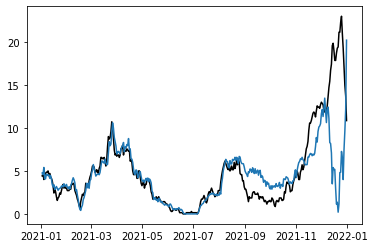

In [198]:
fig, ax = plt.subplots()

ax.plot(df_test.target, label = 'Data', color = 'black')

ax.plot(df_test['median'], label = 'Preds')

plt.show()